### 筆記
* annotation version: tumor as kidney
* INPUT_SIZE = 512
* EPOCHS = 100
* BATCH_SIZE = 2
* 有在Encoder中載入用**noisy-student**方法預訓練的模型參數
* 訓練集: case_00000 ~ case_00209**(訓練影像只包含「腎臟區域預測模型」預測出來的腎臟區域)**
* **窗寬 = 300；窗位 = 50**
* **預先篩除腎臟區域模型預測結果中全黑的影像(影像數量：45424 → 16350)**

### 讀取函式庫、超參數設定

In [1]:
### 讀取函式庫 ###
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

In [2]:
import tensorflow as tf
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [3]:
dataset_dir = 'DATA_0930\\WW300WL50'
x_train_path = 'DATA_0930\\WW300WL50\\train\\images_only_containing_predicted_roi_tumor as kidney'
y_train_path = 'DATA_0930\\WW300WL50\\train\\annotations_tumor only(tumor as 1)'
checkpoints_path = 'DATA_0930\\WW300WL50\\Model_phase2_EfficientNetB4-Unet_1001'
model_name = 'EfficientNetB4-Unet'
start_from_latest_checkpoints = False

INPUT_SIZE = 512 # input size equal to output size
CLASS_NUM = 2 # background and roi(kidney)

# initialize the number of epochs and batch size
EPOCHS = 100
BATCH_SIZE = 2

IMAGE_ORDERING = 'channels_last' # 不要亂改這個參數

### 用生成器(generator)生成訓練圖片
使用generator的好處在於，模型在訓練(或驗證)的過程中會依據批量大小生成圖片，不需要在程式中預先準備好資料集(通常資料集都會大到無法一口氣塞入記憶體之中)，減少記憶體的使用空間。另外，使用ImageDataGenerator可以對生成的圖片實施「資料增強(Data Augmentation)」，增加模型的泛化能力。

In [4]:
### 取得資料集中所有的檔案路徑(包含CT影像和其對應標記的路徑) ###
def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """

    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]

    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension,
                                os.path.join(images_path, dir_entry)))

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
           os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            full_dir_entry = os.path.join(segs_path, dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0}"
                                      " already exists and is ambiguous to"
                                      " resolve with path {1}."
                                      " Please remove or rename the latter."
                                      .format(file_name, full_dir_entry))

            segmentation_files[file_name] = (file_extension, full_dir_entry)

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            return_value.append((image_full_path,
                                segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation "
                                  "found for image {0}."
                                  .format(image_full_path))

    return return_value

### 將CT影像的陣列轉成適合模型輸入的形式(維度轉換 + 標準化) ###
def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first'):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide": # 除以127.5，然後減 1
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean": # 減去ImageNet的平均BGR
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide": # 除以255
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img

### 將標記資料的陣列轉成適合模型輸入的形式(維度轉換) ###
def get_segmentation_array(image_input, nClasses,
                           width, height, no_reshape=False):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_segmentation_array: "
                                  "path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_segmentation_array: "
                              "Can't process input type {0}"
                              .format(str(type(image_input))))

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels

import itertools
import random
from keras.preprocessing.image import ImageDataGenerator

def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width, do_augment=False):

    img_seg_pairs = get_pairs_from_paths(images_path, segs_path) 
        # 取得資料集中所有的檔案路徑(包含CT影像和其對應標記的路徑)
    random.shuffle(img_seg_pairs) # 打散檔案路徑
    zipped = itertools.cycle(img_seg_pairs) 
        # 將檔案路徑用循環迭代器(iterator)封裝；範例：cycle('ABCD') --> A B C D A B C D ...
#     counter = 0

    while True:
        # 如果模型訓練完一輪訓練集中所有的資料，就重新打散檔案路徑
#         if counter >= len(img_seg_pairs):
#             counter = 0
#             random.shuffle(img_seg_pairs)
#             zipped = itertools.cycle(img_seg_pairs)             
        
        X = []
        Y = []
        for _ in range(batch_size): # batch_size多大，就取得多少份資料
#             counter += 1
            
            im, seg = next(zipped) # 取得CT影像和其對應標記的路徑

            im = cv2.imread(im, 1) # 1 = cv2.IMREAD_COLOR (讀取彩色圖片)
            seg = cv2.imread(seg, 1)
            
            if do_augment:
                ### Example of transforming images and masks together. ###
                # we create two instances with the same arguments
                data_gen_args = dict(featurewise_center=False, # 範例程式碼為True，但這裡我只是要把一張圖片變成是增強後的型態
                         featurewise_std_normalization=False, # 範例程式碼為True，但這裡我只是要把一張圖片變成是增強後的型態
                         #rotation_range=30, # 範例程式碼為90
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
                image_datagen = ImageDataGenerator(**data_gen_args)
                mask_datagen = ImageDataGenerator(**data_gen_args)
                # Provide the same seed and keyword arguments to the fit and flow methods
                seed = random.randint(0,10000)
                im_itr = image_datagen.flow(im.reshape(1, 512, 512, 3), batch_size=1, seed=seed)  
                seg_itr = mask_datagen.flow(seg.reshape(1, 512, 512, 3), batch_size=1, seed=seed)  
                im = next(im_itr).reshape(512, 512, 3)
                seg = next(seg_itr).reshape(512, 512, 3)
            
            # 將CT影像和其對應的標記轉換成模型輸入的形式
            X.append(get_image_array(im, input_width,
                                     input_height, imgNorm="sub_mean", ordering=IMAGE_ORDERING)) 
                # imgNorm預設為sub_mean"，但這裡我改用圖片最常實施的正規化方法(同除以255)
            Y.append(get_segmentation_array(
                seg, n_classes, output_width, output_height))

        yield np.array(X), np.array(Y)

Using TensorFlow backend.


In [5]:
# 建立訓練資料的生成器
train_gen = image_segmentation_generator(images_path = x_train_path, segs_path = y_train_path, batch_size = BATCH_SIZE, 
                                         n_classes = CLASS_NUM, input_height = INPUT_SIZE, input_width = INPUT_SIZE, 
                                         output_height = INPUT_SIZE, output_width = INPUT_SIZE, do_augment=False)

### 設定回調函式(callbacks)
keras_segmentation自定義的回調函式好像缺了什麼，直接用在這份程式碼中並不會正常運作，因此我直接用keras.callbacks.ModelCheckpoint定期儲存模型參數。

In [6]:
from keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint(os.path.join(checkpoints_path, model_name + '_{epoch}.h5'), 
                             save_weights_only=True, 
                             period=5)] # period=5：每5個Epoch才會儲存一次參數

### 建立模型

In [7]:
import keras
from keras.models import *
from keras.layers import *
from keras import layers

#### Eecoder - EfficientNetB4

In [8]:
import efficientnet.keras as efn 

model_ = efn.EfficientNetB4(
    input_shape=(INPUT_SIZE,INPUT_SIZE,3), 
    weights='noisy-student'
)

model_.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [9]:
### B4 ###
img_input = model_.get_layer('input_1').output # (None, 512, 512, 3)
f1 = model_.get_layer('block1b_add').output # (None, 256, 256, 24)
f2 = model_.get_layer('block2d_add').output # (None, 128, 128, 32)
f3 = model_.get_layer('block3d_add').output # (None, 64, 64, 56)
f4 = model_.get_layer('block4f_add').output # (None, 32, 32, 112)
f5 = model_.get_layer('block5f_add').output # (None, 32, 32, 160)
f6 = model_.get_layer('block6h_add').output # (None, 16, 16, 272)
f7 = model_.get_layer('block7b_add').output # (None, 16, 16, 448)

#### Decoder

In [10]:
if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

o = f7

#o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f6], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(512, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f5], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(256, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

#o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f4], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(128, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f3], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f2], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f1], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(32, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(32, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = Conv2D(CLASS_NUM, (3, 3), padding='same', data_format=IMAGE_ORDERING)(o) # 輸出層

### 模仿 keras_segmentation 在輸出層之後額外添加這幾層 ###
if IMAGE_ORDERING == 'channels_first':
    o = (Reshape((CLASS_NUM, INPUT_SIZE * INPUT_SIZE)))(o)
    o = (Permute((2, 1)))(o)
elif IMAGE_ORDERING == 'channels_last':
    o = (Reshape((INPUT_SIZE * INPUT_SIZE, CLASS_NUM)))(o)
o = (Activation('softmax'))(o)
###

In [11]:
model = Model(img_input, o)

#### 查看模型架構

B4：
* Total params: 22,355,674
* Trainable params: 22,231,882
* Non-trainable params: 123,792

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

### 編譯模型

In [13]:
st = time.time()

from keras.optimizers import Adam, Adadelta
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adadelta(lr = 1.0),
              metrics = ['accuracy'])

import keras.backend as K
print(K.eval(model.optimizer.lr)) # 確保是1.0

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))

1.0
花費時間(秒)：155.97895765304565


### 訓練模型

In [14]:
st = time.time()
print(f'########## 即將用該資料集進行訓練：{dataset_dir} ##########')

if start_from_latest_checkpoints:
    try:
        model.load_weights(
            os.path.join(
                checkpoints_path, 
                model_name + '_' + str(max([int(i.split('_')[-1][:-3]) for i in os.listdir(checkpoints_path)])) + '.h5'
            )
        )
    except:
        print('Model weights not found!')

if not os.path.exists(checkpoints_path):
    os.makedirs(checkpoints_path)
    print('-----建立新資料夾：' + checkpoints_path + '-----') 


model.fit_generator(
    train_gen,
    steps_per_epoch = 512, 
    #steps_per_epoch = len(x_train) // BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1,
    callbacks=callbacks
)

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))

########## 即將用該資料集進行訓練：DATA_0930\WW300WL50 ##########
Epoch 1/100
512/512 [==============================] - 249s 485ms/step - loss: 0.0697 - accuracy: 0.9910
Epoch 2/100
512/512 [==============================] - 214s 417ms/step - loss: 0.0126 - accuracy: 0.9962
Epoch 3/100
512/512 [==============================] - 214s 417ms/step - loss: 0.0098 - accuracy: 0.9969
Epoch 4/100
512/512 [==============================] - 213s 416ms/step - loss: 0.0076 - accuracy: 0.9976
Epoch 5/100
512/512 [==============================] - 214s 417ms/step - loss: 0.0071 - accuracy: 0.9977
Epoch 6/100
512/512 [==============================] - 214s 417ms/step - loss: 0.0056 - accuracy: 0.9982
Epoch 7/100
512/512 [==============================] - 214s 417ms/step - loss: 0.0051 - accuracy: 0.9983
Epoch 8/100
512/512 [==============================] - 214s 418ms/step - loss: 0.0051 - accuracy: 0.9983
Epoch 9/100
512/512 [==============================] - 214s 418ms/step - loss: 0.0049 - accuracy: 0.9983
E

512/512 [==============================] - 215s 420ms/step - loss: 0.0017 - accuracy: 0.9994
Epoch 78/100
512/512 [==============================] - 214s 418ms/step - loss: 0.0017 - accuracy: 0.9994
Epoch 79/100
512/512 [==============================] - 214s 418ms/step - loss: 0.0016 - accuracy: 0.9995
Epoch 80/100
512/512 [==============================] - 214s 419ms/step - loss: 0.0017 - accuracy: 0.9994
Epoch 81/100
512/512 [==============================] - 215s 420ms/step - loss: 0.0017 - accuracy: 0.9994
Epoch 82/100
512/512 [==============================] - 215s 419ms/step - loss: 0.0019 - accuracy: 0.9993
Epoch 83/100
512/512 [==============================] - 214s 419ms/step - loss: 0.0019 - accuracy: 0.9993
Epoch 84/100
512/512 [==============================] - 214s 419ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 85/100
512/512 [==============================] - 214s 419ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 86/100
512/512 [==============================] - 214

### 對「訓練集」進行預測，並輸出模型預測腎臟腫瘤區域的結果

**載入模型參數**

In [15]:
### 載入模型參數 ###
# model.load_weights(os.path.join(checkpoints_path, model_name + '_' + str(EPOCHS) + '.h5'))

**生成預測結果**

In [16]:
from evaluate import *
preds = predict_from_folder(model, x_train_path, INPUT_SIZE, 2)

100%|████████████████████████████████████████████████████████████████████████████| 16350/16350 [14:25<00:00, 18.90it/s]


**取得訓練集前70位和前140位病患的影像總數(作為之後分批處理資料的切點)**

In [17]:
# ### 取得訓練集前70位和前140位病患的影像總數 ###
# txt_dir = 'DATA_0919\\number of slices of each patient - KiTS_train.txt'
# with open(txt_dir, 'r') as f:
#     data_list = f.read().splitlines()

# print(sum([int(i.split(' ')[1]) for i in data_list[:70]]))
# print(sum([int(i.split(' ')[1]) for i in data_list[:140]]))

**計算評估指標(Evaluation Metric)**

In [18]:
from evaluate import *

st = time.time()

result = evaluate_model(
    image_dir = x_train_path, 
    label_dir = y_train_path,
    checkpoints_path = None,
    calculate_predicting_indicators = True,
    output_predicted_result = False, 
    segment_out_predicted_region_from_original_images = False, 
    roi_description = 'tumor only(tumor as 1)', 
    preds = preds,
    batch_process_slice_point = None)

print('訓練集預測結果：')
print(f'average Dice score per case of kidney: {result[0]: .4f}')
print(f'average recall of kidney: {result[1]: .4f}')
print(f'average precision of kidney: {result[2]: .4f}')
print(f'global dice score of kidney: {result[3]: .4f}')
print('')
print('混淆矩陣：')
print(f'True Positive: {result[-4]}')
print(f'False Positive: {result[-3]}')
print(f'False Negative: {result[-2]}')
print(f'True Negative: {result[-1]}')

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))

----------預測結果資料型態轉換(第1批資料)----------
----------開始計算各項預測指標(第1批資料)----------
目前進度：第500張照片
目前進度：第1000張照片
目前進度：第1500張照片
目前進度：第2000張照片
目前進度：第2500張照片
目前進度：第3000張照片
目前進度：第3500張照片
目前進度：第4000張照片
目前進度：第4500張照片
目前進度：第5000張照片
目前進度：第5500張照片
目前進度：第6000張照片
目前進度：第6500張照片
目前進度：第7000張照片
目前進度：第7500張照片
目前進度：第8000張照片
目前進度：第8500張照片
目前進度：第9000張照片
目前進度：第9500張照片
目前進度：第10000張照片
目前進度：第10500張照片
目前進度：第11000張照片
目前進度：第11500張照片
目前進度：第12000張照片
目前進度：第12500張照片
目前進度：第13000張照片
目前進度：第13500張照片
目前進度：第14000張照片
目前進度：第14500張照片
目前進度：第15000張照片
目前進度：第15500張照片
目前進度：第16000張照片
total case number: 16350
訓練集預測結果：
average Dice score per case of kidney:  0.6338
average recall of kidney:  0.5458
average precision of kidney:  0.8738
global dice score of kidney:  0.9133

混淆矩陣：
True Positive: 4431
False Positive: 94
False Negative: 1246
True Negative: 10579
花費時間(秒)：1312.5383608341217


In [19]:
patient_idx_train = list(range(0,210))

dice_score_list = result[5]
print('訓練集各病患的 Dice score:')
for idx, i in enumerate(dice_score_list):
    print(f'case{patient_idx_train[idx]}: {i: .4f}')

訓練集各病患的 Dice score:
case0:  0.1810
case1:  0.3005
case2:  0.9159
case3:  0.7368
case4:  0.4693
case5:  0.7848
case6:  0.4076
case7:  0.1755
case8:  0.9318
case9:  0.4649
case10:  0.1097
case11:  0.9002
case12:  0.9237
case13:  0.8480
case14:  0.0015
case15:  0.3278
case16:  0.8303
case17:  0.6460
case18:  0.1239
case19:  0.0000
case20:  0.0000
case21:  0.8370
case22:  0.4639
case23:  0.0000
case24:  0.9440
case25:  0.9664
case26:  0.8692
case27:  0.4985
case28:  0.9088
case29:  0.8784
case30:  0.9630
case31:  0.7115
case32:  0.7619
case33:  0.4237
case34:  0.6680
case35:  0.8170
case36:  0.8483
case37:  0.9263
case38:  0.8878
case39:  0.2711
case40:  0.4800
case41:  0.5649
case42:  0.9412
case43:  0.3359
case44:  0.9198
case45:  0.7867
case46:  0.8870
case47:  0.7839
case48:  0.7653
case49:  0.3072
case50:  0.2693
case51:  0.6480
case52:  0.5820
case53:  0.9086
case54:  0.1144
case55:  0.9002
case56:  0.9508
case57:  0.8635
case58:  0.8240
case59:  0.7052
case60:  0.7905
case61:  0.771

**輸出模型的預測結果**

In [20]:
from evaluate import *

st = time.time()

_ = evaluate_model(
    image_dir = x_train_path, 
    label_dir = y_train_path, 
    checkpoints_path = None,
    calculate_predicting_indicators = False,
    output_predicted_result = True, 
    segment_out_predicted_region_from_original_images = False, 
    roi_description = 'tumor only(tumor as 1)', 
    preds = preds,
    batch_process_slice_point = None)

ed = time.time()
spend_time = ed - st
print('花費時間(秒)：' + str(spend_time))

----------預測結果資料型態轉換(第1批資料)----------
-----建立新資料夾：DATA_0930\WW300WL50\train\annotations_tumor only(tumor as 1)_predicted-----
---------開始輸出模型預測結果(第1批資料)----------
目前進度：第500張照片
目前進度：第1000張照片
目前進度：第1500張照片
目前進度：第2000張照片
目前進度：第2500張照片
目前進度：第3000張照片
目前進度：第3500張照片
目前進度：第4000張照片
目前進度：第4500張照片
目前進度：第5000張照片
目前進度：第5500張照片
目前進度：第6000張照片
目前進度：第6500張照片
目前進度：第7000張照片
目前進度：第7500張照片
目前進度：第8000張照片
目前進度：第8500張照片
目前進度：第9000張照片
目前進度：第9500張照片
目前進度：第10000張照片
目前進度：第10500張照片
目前進度：第11000張照片
目前進度：第11500張照片
目前進度：第12000張照片
目前進度：第12500張照片
目前進度：第13000張照片
目前進度：第13500張照片
目前進度：第14000張照片
目前進度：第14500張照片
目前進度：第15000張照片
目前進度：第15500張照片
目前進度：第16000張照片
total case number: 16350
花費時間(秒)：958.9035441875458


**隨機印出模型預測結果**

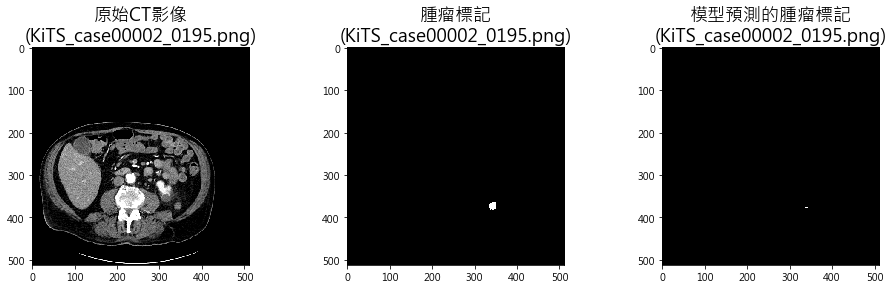

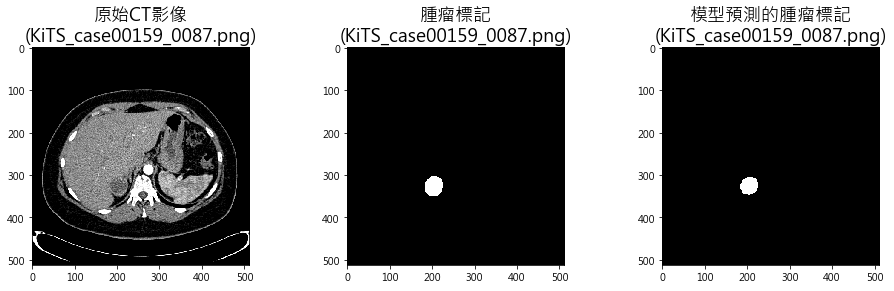

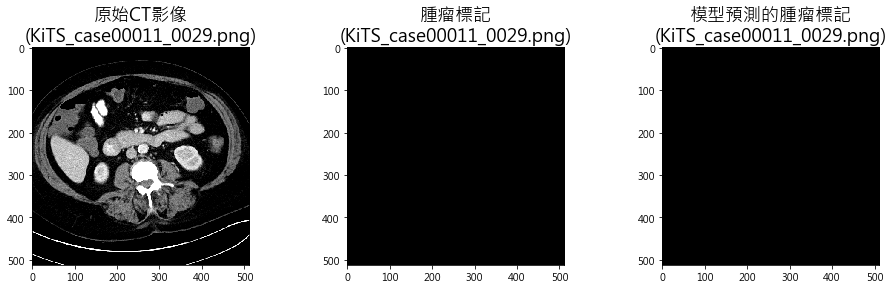

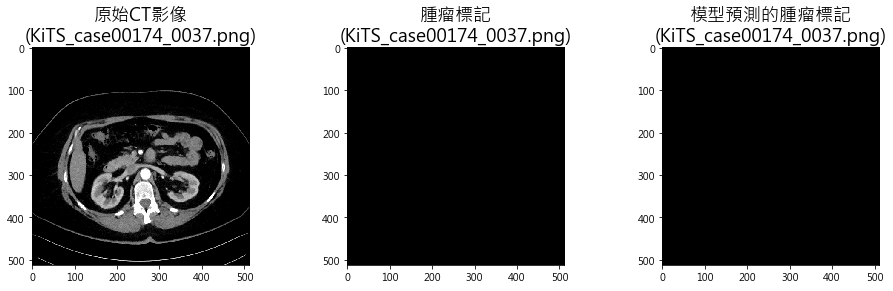

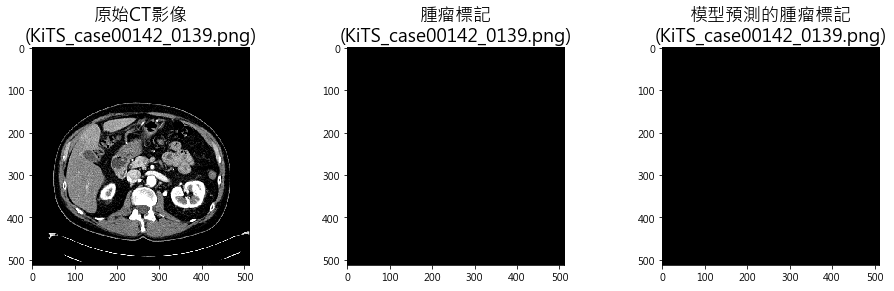

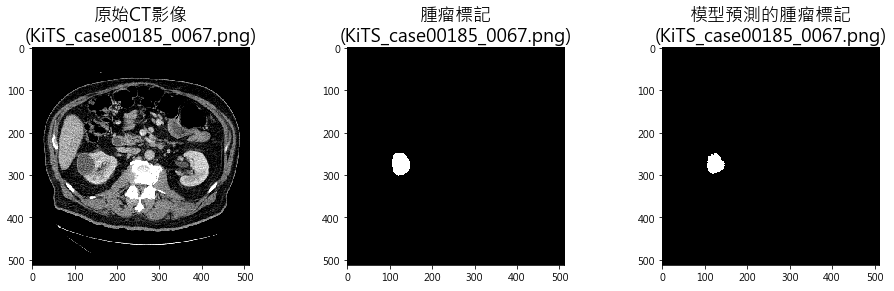

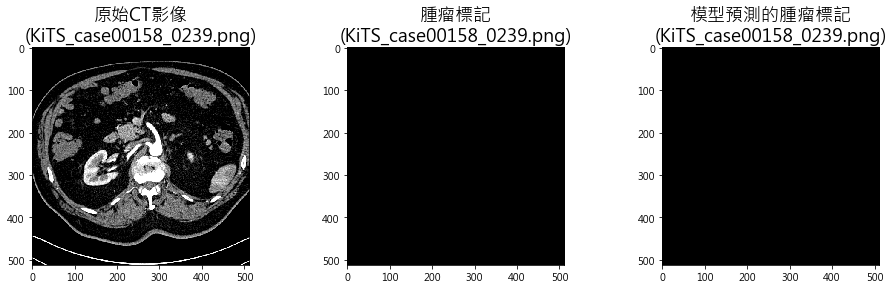

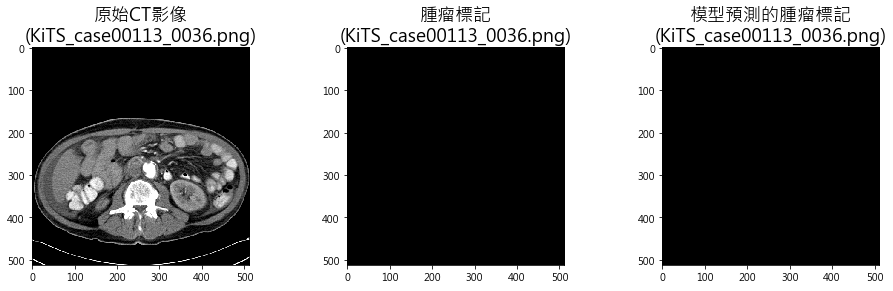

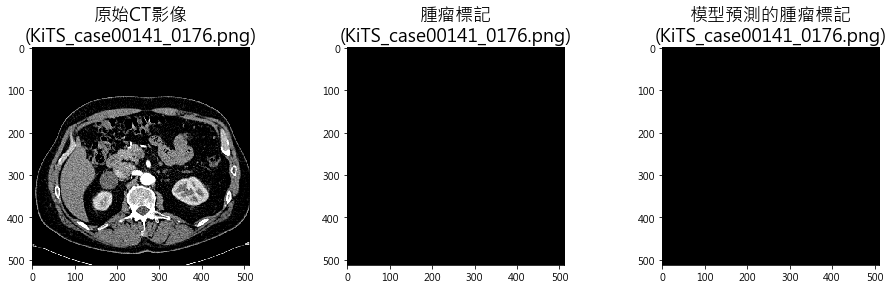

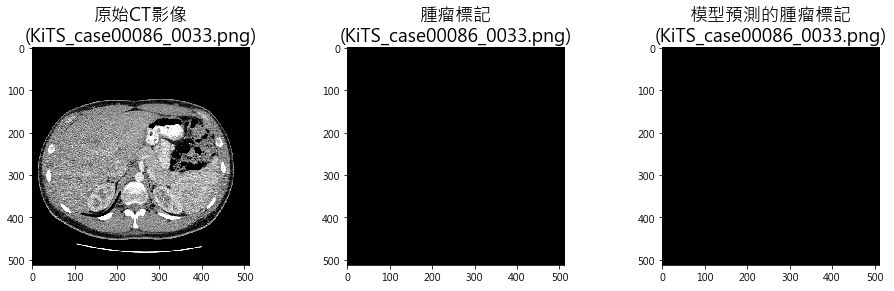

In [63]:
## 隨機印出模型預測訓練集的結果 ###
show_result(
    target_dataset_base_dir = 'DATA_0930\\WW300WL50\\train',
    result_num = 10,
    roi_description = 'tumor only(tumor as 1)', 
    roi_name_chinese = '腫瘤',
    show_predicted_result = True,
    show_segmentation_result = False, 
    image_scale = 4)